 # Feature Engineering

Feature engineering is about creativity. It is the part of the model development process where data scientists can employ their experience, business context and creativity to tailor the model and capture why churn happens in a specific business.

When modelling churn you will want to test a mix of features related to customer engagement, customer demographics, product and pricing as well as customer satisfaction data, if available.

Features are measurable characteristics from customers historical data that a machine learning model takes into account to predict future outcomes.
In the feature engineering process, a set of attributes that represent behaviour patterns related to the engagment level of PowerCO's SME customers.

From the available and clean data, the drivers of churn for our client could be:
* Loyal customers vs new customers - which ones tend to churn more?
* scope for discounts or offers to loyal customers

Features to be created
* Deep dive into dates using tenure instead; contract end date - contact start date
* An overview of churn data over the year, month by month view and quarterly basis


## Contents
1. Import libraries 
2. Load the data
3. Feature Engineering
4. Removing outliers
5. Multicolliearity
6. Pickling

## 1. Import packages

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

In [2]:
# to show plots in jupyter notebook
%matplotlib inline

In [3]:
#set plot style
sns.set(color_codes=True)

In [4]:
# Set maximum number of columns to be displayed
pd.set_option('display.max_columns', 100)

## 2. Load the data

#### Directory for the data
Paths used are indicated using the pickle data format from the data cleaning stage

In [5]:
PICKLE_TRAIN_DIR = os.path.join("..", "processed_data", "train_data.pkl")
PICKLE_HISTORY_DIR = os.path.join("..", "processed_data", "history_data.pkl")

In [6]:
#Load the data into the dataframe
train = pd.read_pickle(PICKLE_TRAIN_DIR)
history_data = pd.read_pickle(PICKLE_HISTORY_DIR)

## 3. Feature Engineering

Will create new features using the average of the year for our model since we have the consumption data for each of of the energy (var) and power (fix) companies.

In [7]:
mean_year = history_data.groupby(["id"]).mean().reset_index()

In [8]:
#combine it into a single dataframe

mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var",
                                                "price_p2_var": "mean_year_price_p2_var",
                                                 "price_p3_var": "mean_year_price_p3_var",
                                                 "price_p1_fix": "mean_year_price_p1_fix",
                                                 "price_p2_fix": "mean_year_price_p2_fix",
                                                 "price_p3_fix": "mean_year_price_p3_fix"})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

In [9]:
#merge them into the single dataframe
features = mean_year

As mentioned in the introduction, one of the features we can create is a tenure; contract end date - contact start date, which will give us a deep dive into the churn by dates.

The reason for this is that the visualisations in the EDA step where the churn by dates where created, I found that this visualisation did not provide any relevant insight.

With the tenure, I will be able to see if the contract length date i.e. loyal vs new customers are a driver of churn.


tenure = date_end - date_activ

In [10]:
pd.DataFrame({"Dataframe columns": train.columns})

,Dataframe columns
0,id
1,activity_new
2,channel_sales
3,cons_12m
4,cons_gas_12m
5,cons_last_month
6,date_activ
7,date_end
8,date_modif_prod
9,date_renewal


In [11]:
train["tenure"] = ((train["date_end"]-train["date_activ"])/ np.timedelta64(1, "Y")).astype(int)

In [12]:
tenure = train[["tenure", "churn", "id"]].groupby(["tenure", "churn"])["id"].count().unstack(level=1)
tenure_percentage = (tenure.div(tenure.sum(axis=1), axis=0)*100)

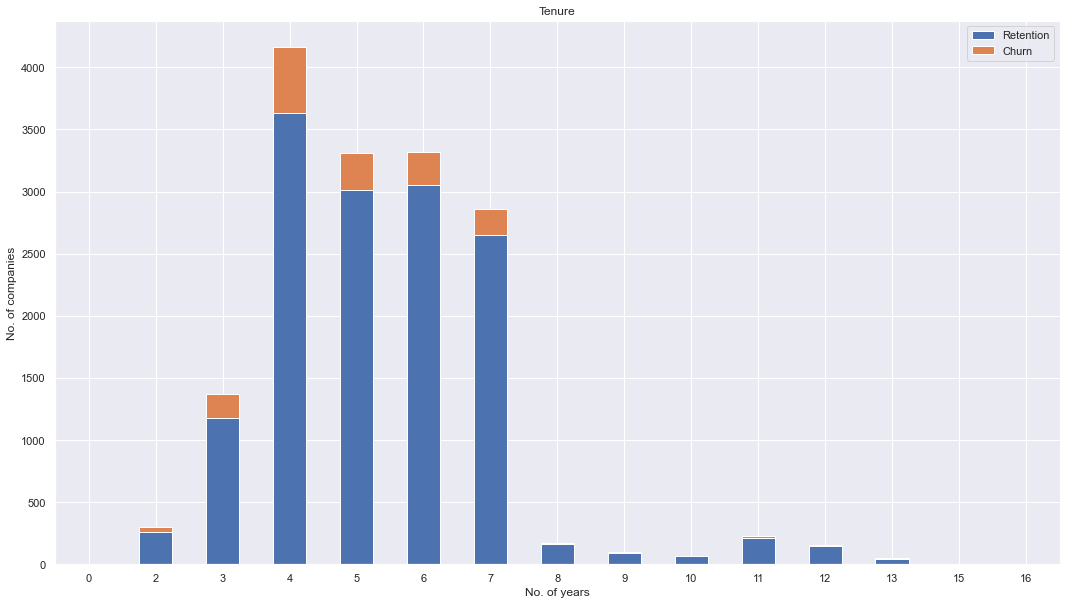

In [13]:
tenure.plot(kind="bar",
                    figsize=(18,10),
                    stacked=True,
                    rot=0,
                    title="Tenure")
#Rename legend
plt.legend(["Retention", "Churn"], loc="upper right")

#Labels
plt.ylabel("No. of companies")
plt.xlabel("No. of years")
plt.show()

We can see that the churn is high for companies who have had their contracts within 3-7 years. We can also clearly see that the churn is very low for companies which joined recently (less than 2 years ago) or have made been with PowerCo for a very long time.

Transform dates provided in such a way that I can make more sense out of them

#### Create month columns

To create the month column:
1. Subtract the reference date (Jan 2016) and the column date
2. Convert the timedelta in months (using the same process for converting timedelta in years for tenure shown above)
3. Convert to integer (whole number, as decimal months are of no use).


In [14]:
def convert_months(reference_date, dataframe, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = REFERENCE_DATE - dataframe[column]
    months = (time_delta / np.timedelta64(1, "M")).astype(int)
    return months

In [15]:
#Create the reference date as provided
REFERENCE_DATE = datetime.datetime(2016,1,1)

In [16]:
#transform the dates
train["months_activ"] = convert_months(REFERENCE_DATE, train, "date_activ")
train["months_to_end"] = -convert_months(REFERENCE_DATE, train, "date_end")
train["months_renewal"] = convert_months(REFERENCE_DATE, train, "date_renewal")

Plot for insights for churn by months

In [17]:
def plot_churn_by_month (dataframe, column, fontsize_=11):
    """
    Plot churn distribution by monthly variable
    """
    temp = dataframe[[column, "churn", "id"]].groupby([column, "churn"])["id"].count().unstack(level=1)
    temp.plot(kind="bar",
                        figsize=(18,10),
                        stacked=True,
                        rot=0,
                        title=column)
    #Rename legend
    plt.legend(["Retention", "Churn"], loc = "upper right")
    
    #Labels
    plt.ylabel("No. of companies")
    plt.xlabel("No. of months")
    plt.show()

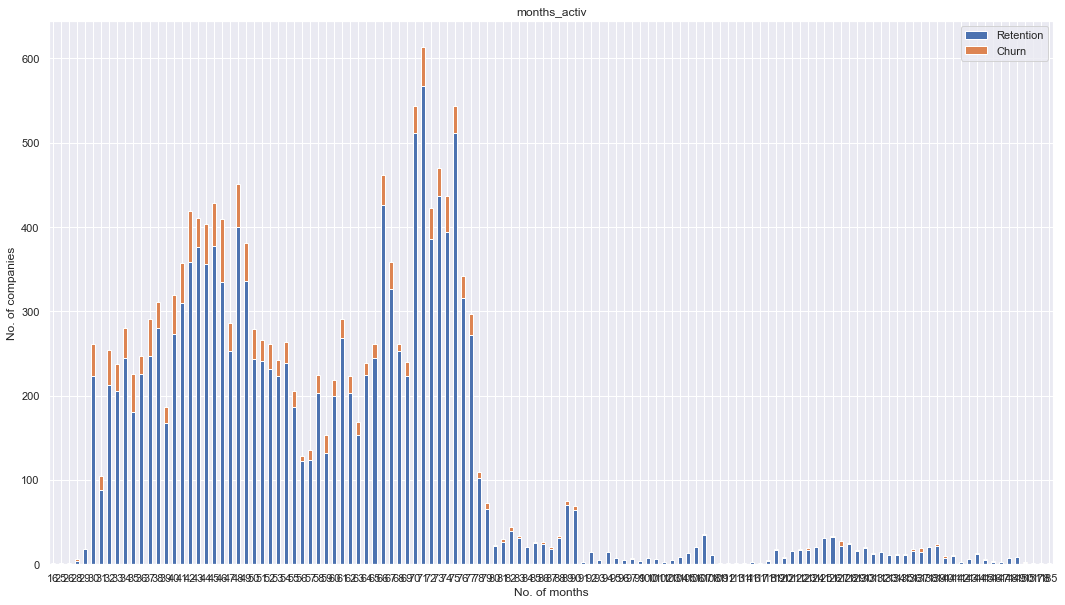

In [18]:
plot_churn_by_month(train, "months_activ", 7)

Explain!

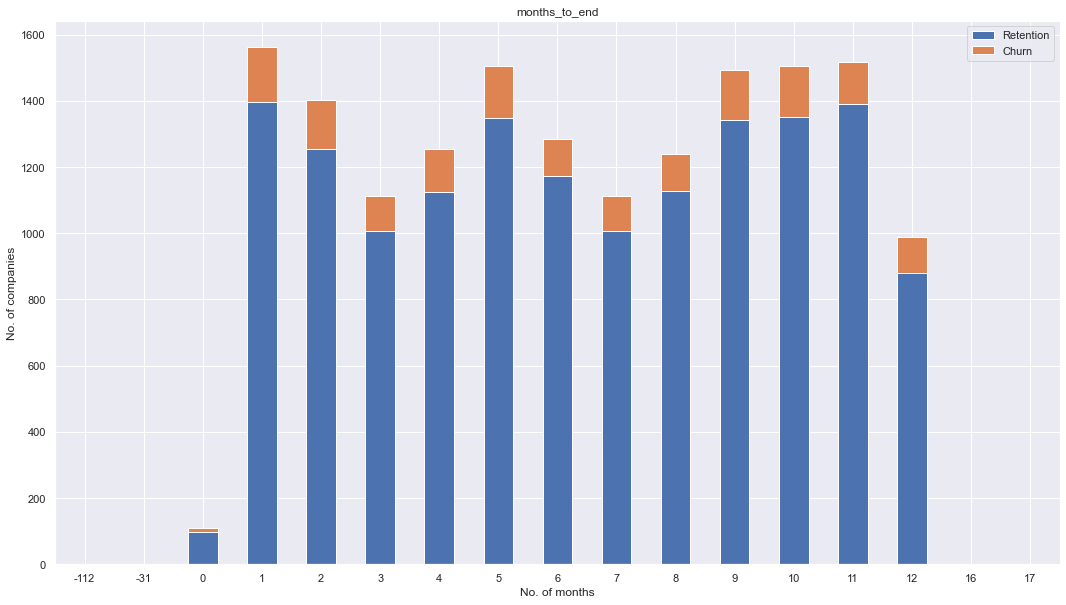

In [19]:
plot_churn_by_month(train, "months_to_end")

Explain!

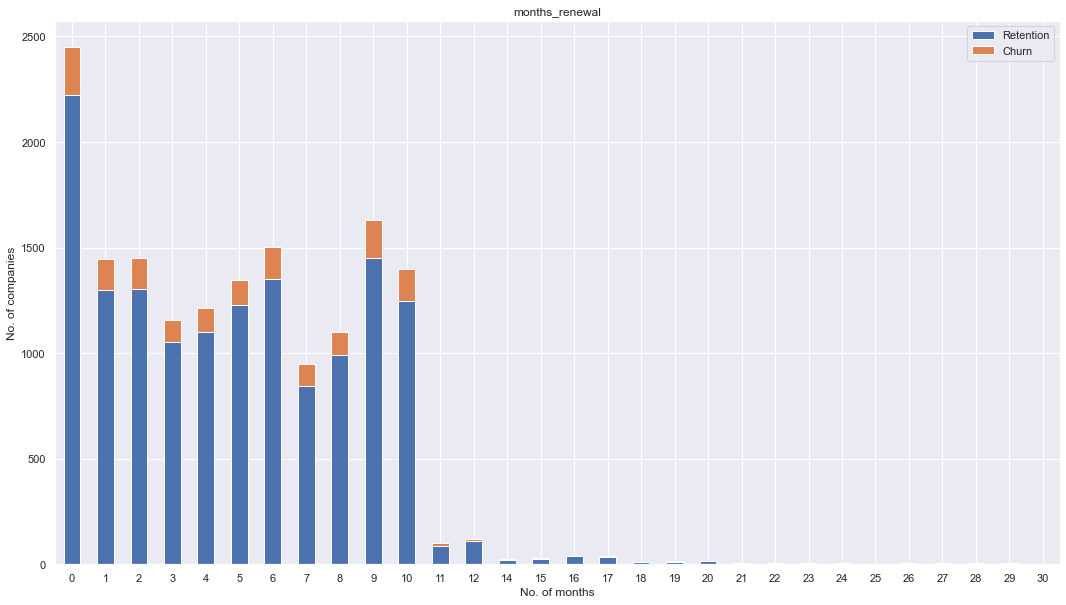

In [20]:
plot_churn_by_month(train, "months_renewal")

Explain!

In [21]:
#remove the date columns created for insights

train.drop(columns=["date_activ", "date_end", "date_renewal"],inplace=True)

### Transforming boolean data
Using onehot encoding to transform column `has_gas` to replace t for 1 and f for 0

In [22]:
train["has_gas"]=train["has_gas"].replace(["t","f"], [1,0])

### Categorical data and dummy variables

When training the model, string data cannot be used so will need to encode it into numerical data. The method used is the `dummy varibales` or `onehot encoder`

Dummy variable -  where variables take only one of two values; used for variables that are qualitative rather then quantitative


The columns with categorical data that will need dummy variables are:
- channel_sales
- activity_new
- origin_up

#### Categorical data `channel_sales`

Convert each category into a new dummy variable which will have 0s and 1s depending whether than entry belongs to that particular category or not

Replace the Nan values with a string called null_values_channel

In [23]:
train["channel_sales"] = train["channel_sales"].fillna("null_values_channel")

In [24]:
#transform to categorical data type
train["channel_sales"] = train["channel_sales"].astype("category")

Check how many categories there are, in order to determine how many dummy variables to create

In [25]:
pd.DataFrame({"Samples in category": train["channel_sales"].value_counts()})

,Samples in category
foosdfpfkusacimwkcsosbicdxkicaua,7377
null_values_channel,4218
lmkebamcaaclubfxadlmueccxoimlema,2073
usilxuppasemubllopkaafesmlibmsdf,1444
ewpakwlliwisiwduibdlfmalxowmwpci,966
sddiedcslfslkckwlfkdpoeeailfpeds,12
epumfxlbckeskwekxbiuasklxalciiuu,4
fixdbufsefwooaasfcxdxadsiekoceaa,2


As there are 8 different categories, 8 dummy variables will be created; one for each column

In [26]:
#create dummy variable
categories_channel = pd.get_dummies(train["channel_sales"], prefix = "channel")

In [27]:
categories_channel.head(3)

,channel_epumfxlbckeskwekxbiuasklxalciiuu,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_fixdbufsefwooaasfcxdxadsiekoceaa,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_null_values_channel,channel_sddiedcslfslkckwlfkdpoeeailfpeds,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0


In [28]:
#rename columns for simplicity
categories_channel.columns = [col_name[:11] for col_name in categories_channel.columns]

In [29]:
categories_channel.head(3)

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_nul,channel_sdd,channel_usi
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0


The `Dummy Variable Trap` is a scenario where the independent variables are `multicollinear`. This is when two or more variables are highly correlated; one variable can be predicted from the others.

To avoid the Dummy Variable Trap, will drop one of the categorical variables

In [30]:
categories_channel.drop(columns=["channel_nul"],inplace=True)

#### Categorical data `activity_new`

Replace Nan values with null_values_origin

In [31]:
train["activity_new"] = train["activity_new"].fillna("null_values_origin")

In [32]:
#transform to category data type
train["activity_new"] = train["activity_new"].astype("category")

Check how many categories there are to determine how many dummy variables to create

In [33]:
categories_activity = pd.DataFrame({"Activity samples": train["activity_new"].value_counts()})
categories_activity

,Activity samples
null_values_origin,9545
apdekpcbwosbxepsfxclislboipuxpop,1577
kkklcdamwfafdcfwofuscwfwadblfmce,422
kwuslieomapmswolewpobpplkaooaaew,230
fmwdwsxillemwbbwelxsampiuwwpcdcb,219
...,...
wmmewikwxokcsaabsuomspccidbawxaf,1
oclxmuppafkockbpkiuksfomiuaeiosm,1
fexixikcmkbfdsexdlmaiswcdxbifsmm,1
ocskiadudoffubcmbomoslkcddxwfsuf,1


As shown in the above, there are too many categories (420) with very few number of samples. In this case, the categories with less than 100 samples will be replaces by null_values_origin. 

In [34]:
#Get the categories with less than 100 samples
to_replace = list(categories_activity[categories_activity["Activity samples"] <= 100].index)
#Replace them with 'null_values_categories'
train["activity_new"] = train["activity_new"].replace(to_replace, "null_values_activity")

In [35]:
#check number of categories
categories_activity = pd.DataFrame({"Activity samples": train["activity_new"].value_counts()})
categories_activity

,Activity samples
null_values_origin,9545
null_values_activity,3554
apdekpcbwosbxepsfxclislboipuxpop,1577
kkklcdamwfafdcfwofuscwfwadblfmce,422
kwuslieomapmswolewpobpplkaooaaew,230
fmwdwsxillemwbbwelxsampiuwwpcdcb,219
ckfxocssowaeipxueikxcmaxdmcduxsa,189
cwofmuicebbcmiaaxufmfimpowpacobu,122
wxemiwkumpibllwklfbcooafckufkdlm,119
cluecxlameloamldmasudocsbmaoamdw,119


There are 10 categories in the activity_new column, so 10 dummy variables will be created.

In [36]:
#Create dummy variable
categories_activity = pd.get_dummies(train["activity_new"], prefix = 'activity')

In [37]:
categories_activity.head(3)

,activity_apdekpcbwosbxepsfxclislboipuxpop,activity_ckfxocssowaeipxueikxcmaxdmcduxsa,activity_cluecxlameloamldmasudocsbmaoamdw,activity_cwofmuicebbcmiaaxufmfimpowpacobu,activity_fmwdwsxillemwbbwelxsampiuwwpcdcb,activity_kkklcdamwfafdcfwofuscwfwadblfmce,activity_kwuslieomapmswolewpobpplkaooaaew,activity_null_values_origin,activity_null_values_activity,activity_wxemiwkumpibllwklfbcooafckufkdlm
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0


In [38]:
#rename columns for simplicity
categories_activity.columns = [col_name[:12] for col_name in categories_activity.columns]

In [39]:
categories_activity.head(3)

,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_nul,activity_wxe
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0


Remove one column to avoid the dummy variable trap

In [40]:
categories_activity.drop(columns=["activity_nul"],inplace=True)

#### Categorical data `origin_up`

Replace all the Nan values with string called null_values_origin

In [41]:
train["origin_up"] = train["origin_up"].fillna("null_values_orgin")

In [42]:
train["origin_up"] = train["origin_up"].astype("category")

Check how many dummy variables to create

In [43]:
pd.DataFrame({"Origin samples": train["origin_up"].value_counts()})

,Origin samples
lxidpiddsbxsbosboudacockeimpuepw,7825
kamkkxfxxuwbdslkwifmmcsiusiuosws,4517
ldkssxwpmemidmecebumciepifcamkci,3664
null_values_orgin,87
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


6 dummy variables to be created

In [44]:
categories_origin = pd.get_dummies(train["origin_up"], prefix = 'origin')

In [45]:
#rename columns for simplicity
categories_origin.columns = [col_name[:10] for col_name in categories_origin.columns]

In [46]:
categories_origin.head(4)

,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_nul,origin_usa
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0


In [47]:
categories_origin.drop(columns=["origin_nul"],inplace=True)

#### Merge dummy variables to main dataframe

Will merge all the new categories into our main dataframe and remove the old categorical columns

In [48]:
# Use common index to merge
train = pd.merge(train, categories_channel, left_index=True, right_index=True)
train = pd.merge(train, categories_origin, left_index=True, right_index=True)
train = pd.merge(train, categories_activity, left_index=True, right_index=True)

In [49]:
train.drop(columns=["channel_sales", "origin_up", "activity_new"],inplace=True)

### Log Transformation

In the previous Exploratory Data Analysis steps, we found that the consumption data is highly skewed to the right, showing very long right-tails towards to the higher values of the distribution. 

As predictive modelling will be used in further steps, it requires variables to be 'normally distributed'. Therefore, the model will perform badly if the data is highly skewed.

To reduce skewness methods such as square root, cube root and log. can be used. Log transformation will be used here which is highly recommended for right skewed data.

In [50]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_to_end,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,0.184145,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,0.387615,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,0.000000,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,0.000000,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,0.000000,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,1.000000,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000,16.000000,185.000000,17.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000

Log transformation does not work with negative data, so will convert the negative vlaues to NaN. Also, log transformations cannot be applied to 0 valued entries, so will add a constant 1.

In [51]:
# Remove the negative values from consumption data (the highly skewed being transformed)
train.loc[train.cons_12m < 0,"cons_12m"] = np.nan
train.loc[train.cons_gas_12m < 0,"cons_gas_12m"] = np.nan
train.loc[train.cons_last_month < 0,"cons_last_month"] = np.nan
train.loc[train.forecast_cons_12m < 0,"forecast_cons_12m"] = np.nan
train.loc[train.forecast_cons_year < 0,"forecast_cons_year"] = np.nan
train.loc[train.forecast_meter_rent_12m < 0,"forecast_meter_rent_12m"] = np.nan
train.loc[train.imp_cons < 0,"imp_cons"] = np.nan

In [52]:
# Apply log10 transformation
train["cons_12m"] = np.log10(train["cons_12m"]+1)
train["cons_gas_12m"] = np.log10(train["cons_gas_12m"]+1)
train["cons_last_month"] = np.log10(train["cons_last_month"]+1)
train["forecast_cons_12m"] = np.log10(train["forecast_cons_12m"]+1)
train["forecast_cons_year"] = np.log10(train["forecast_cons_year"]+1)
train["forecast_meter_rent_12m"] =  np.log10(train["forecast_meter_rent_12m"]+1)
train["imp_cons"] = np.log10(train["imp_cons"]+1)

Plot the distribution of the consumption data to visualise changes to skew

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

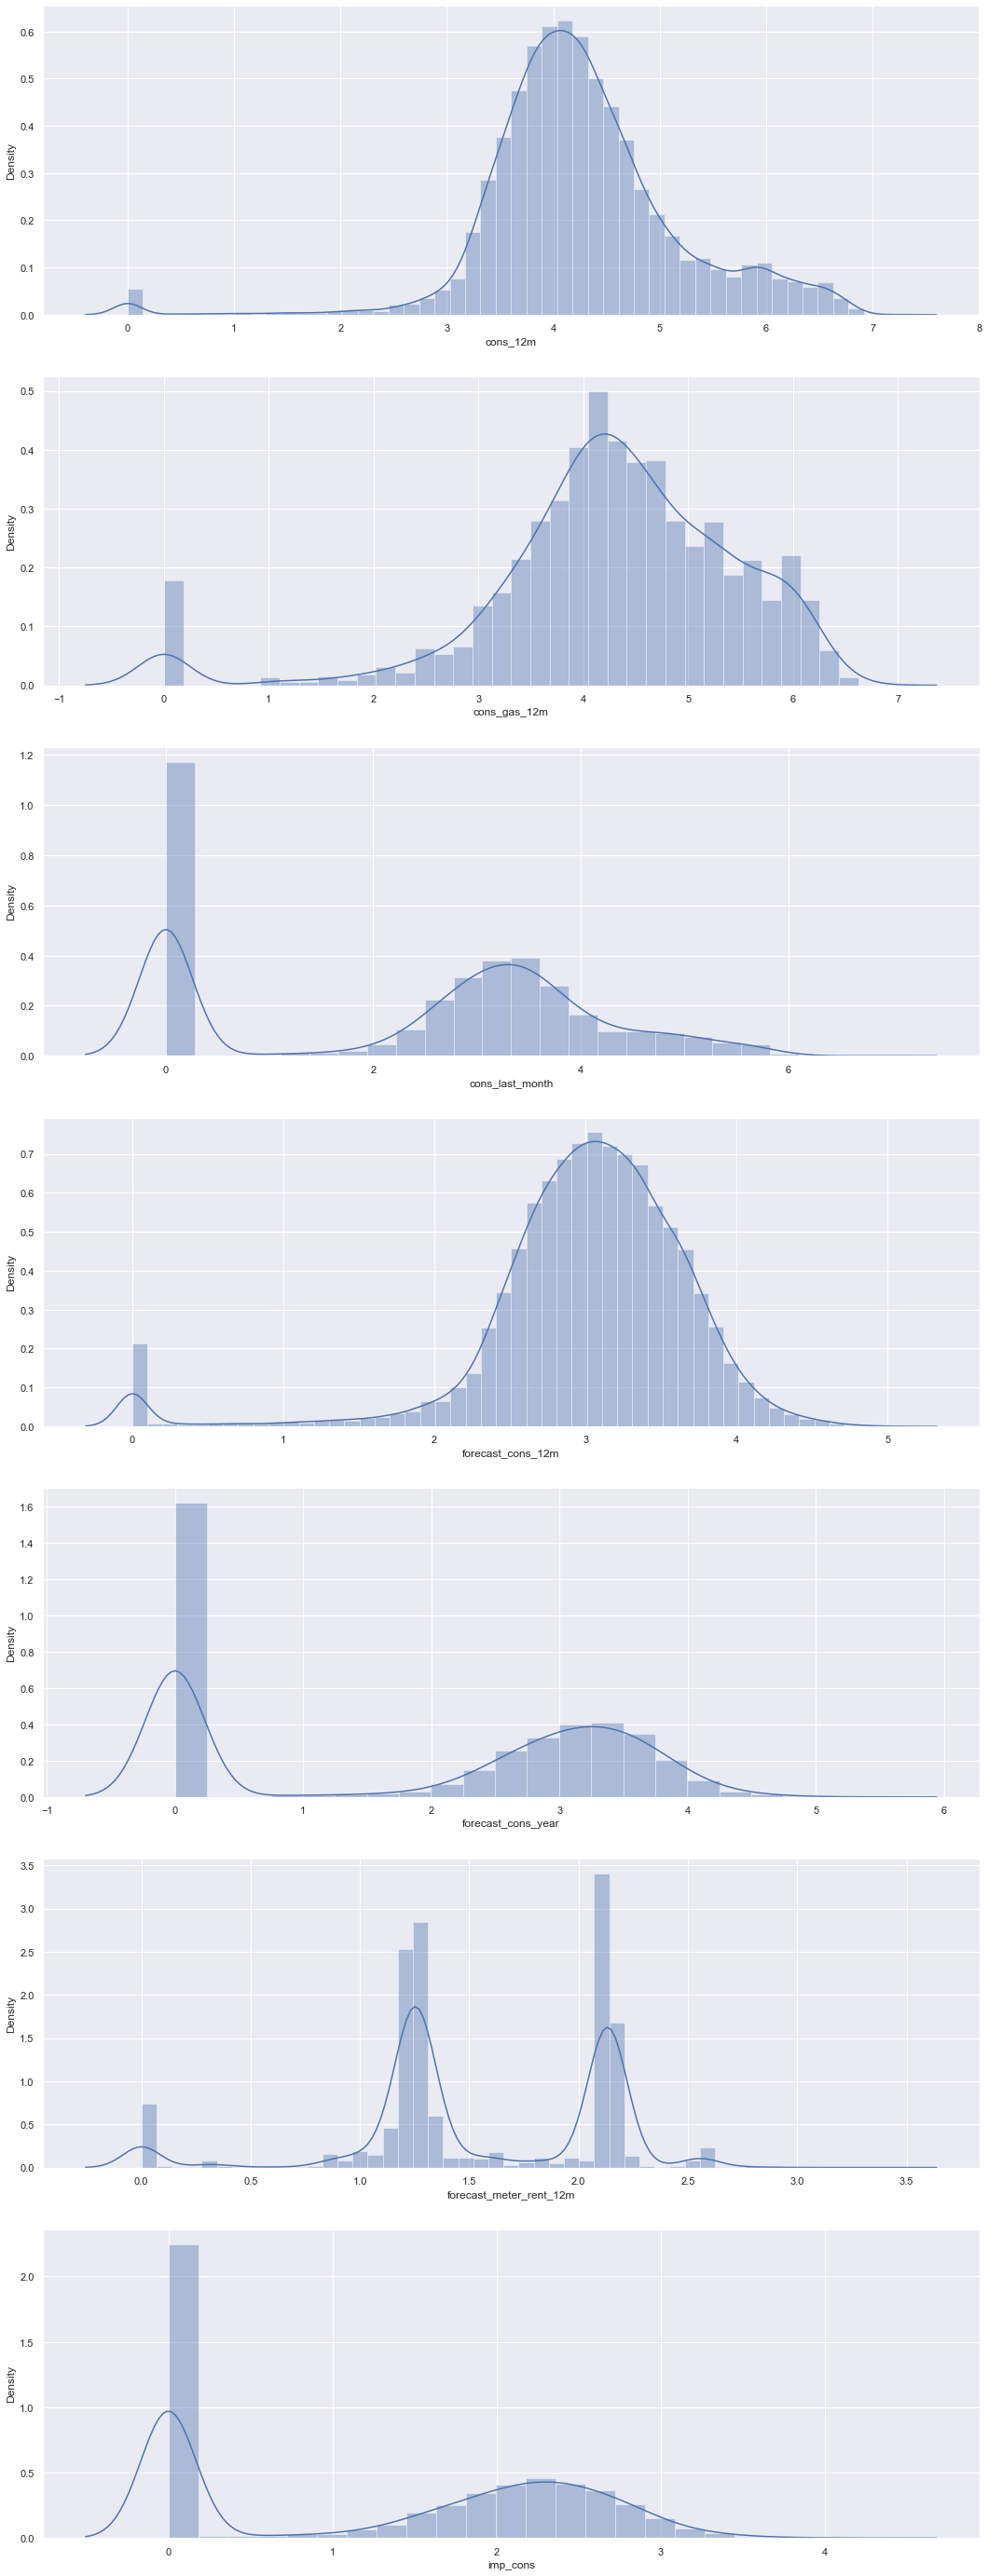

In [53]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
#Plot histograms
sns.distplot((train["cons_12m"].dropna()), ax=axs[0])
sns.distplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.distplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.distplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.distplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.distplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

From the histograms plotted above, the distributions look much closer to normal distributions

In [54]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_to_end,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_wxe
count,16069.000000,16090.000000,16050.000000,16055.000000,16071.000000,15970.000000,16092.000000,15970.000000,15970.000000,15970.000000,16096.000000,16069.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,4.283812,0.800300,2.359281,3.006826,1.869956,0.991547,1.549610,0.135901,0.052951,43.533496,0.184145,1.305021,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.007393
std,0.915265,1.748833,1.789067,0.709778,1.612963,5.160969,0.589394,0.026252,0.048617,5.212252,0.387615,1.165532,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.085668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.122184,0.000000,0.000000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.773786,0.000000,0.000000,2.713952,0.000000,0.000000,1.236285,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.187408,0.000000,2.959041,3.073579,2.583199,0.000000,1.310481,0.142881,0.086163,44.311378,0.000000,1.662380,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.701508,0.000000,3.617000,3.430950,3.301030,0.000000,2.122126,0.146348,0.098837,44.311378,0.000000,2.341118,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,59.444710,1.000000,4.177357,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000,16.000000,185.000000,17.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plot boxplots for outliers

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/si

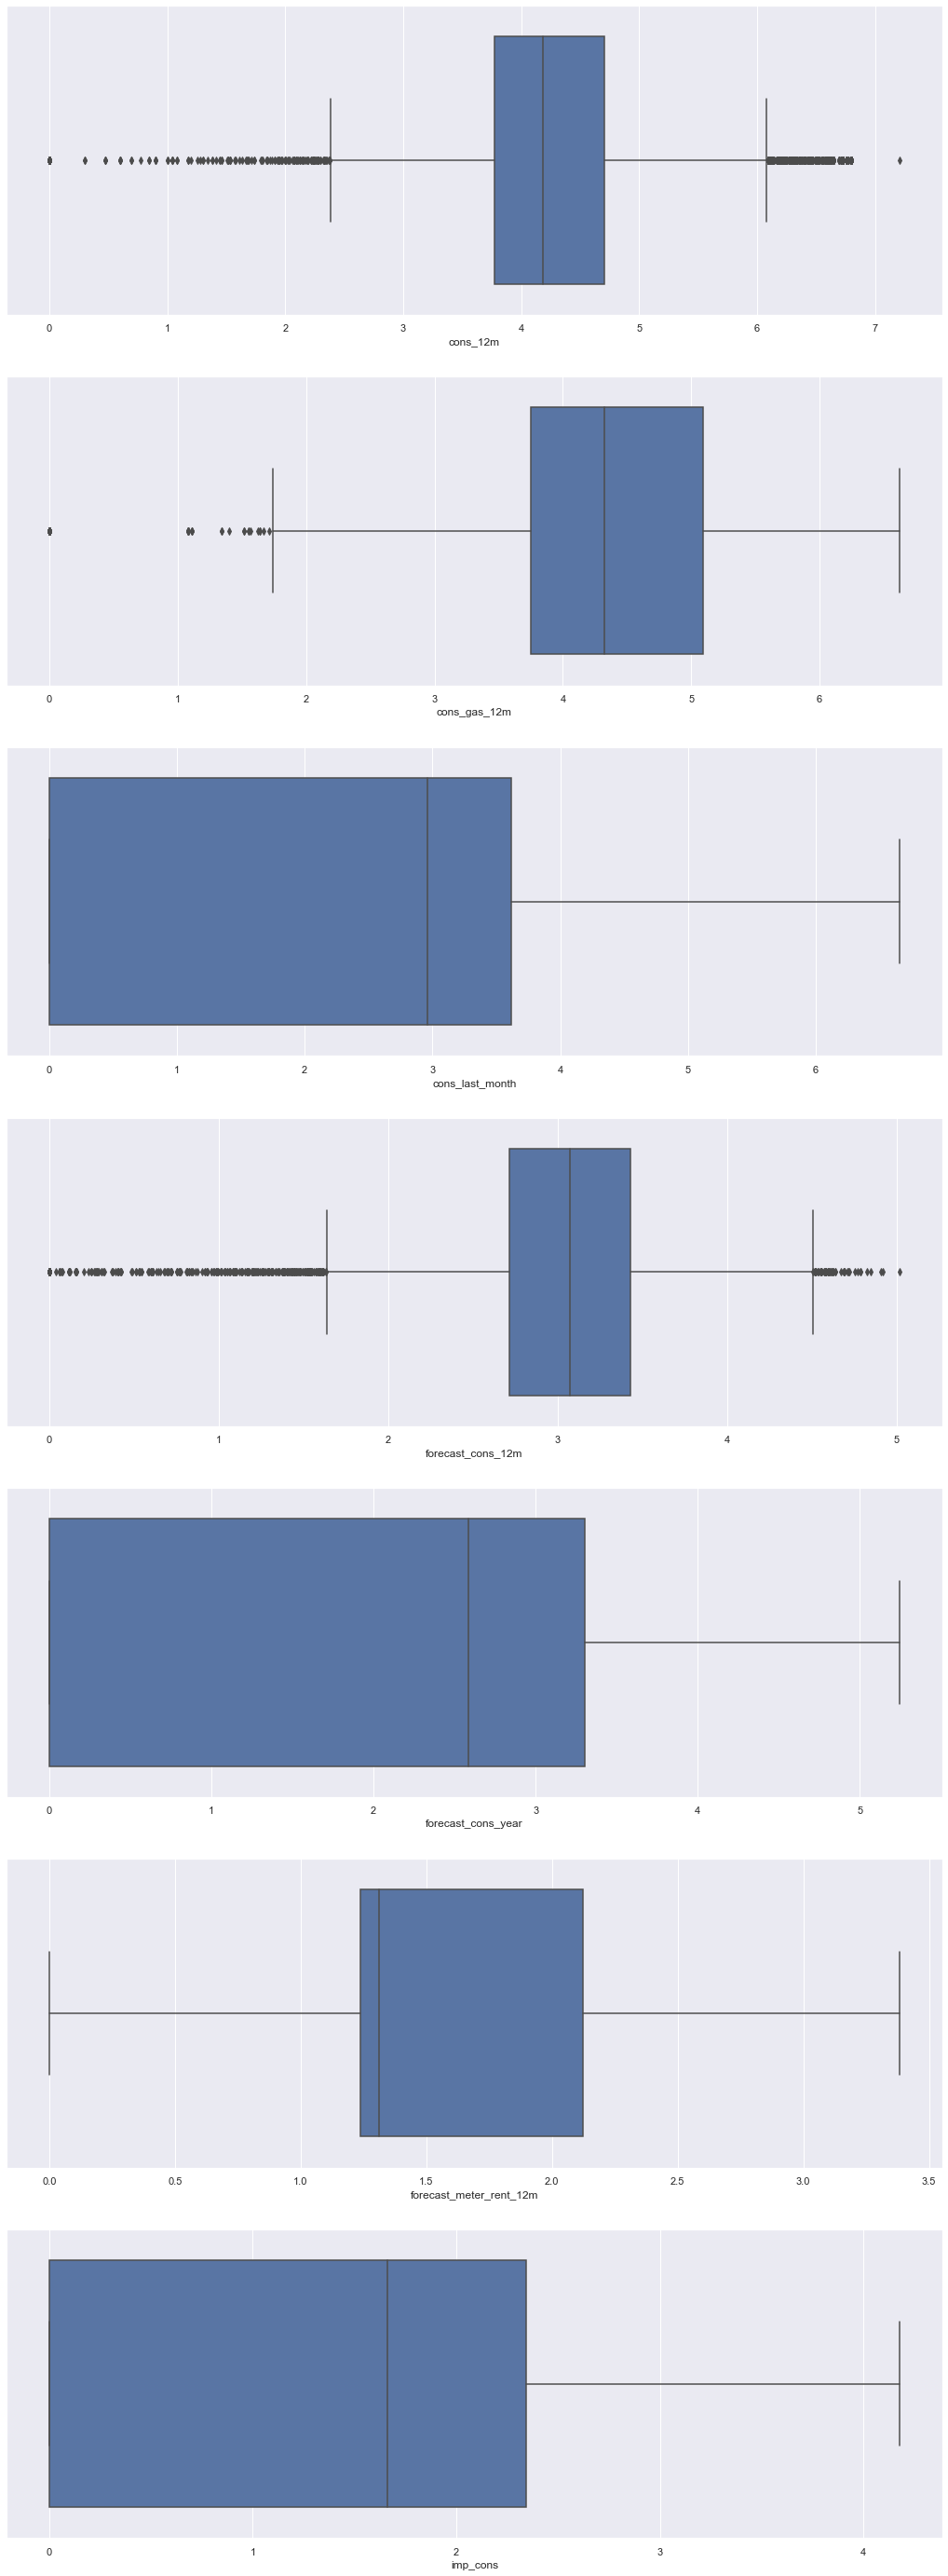

In [55]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

From the boxplots above, we can still see some of the values are quite far from the range (outliers).

## 4. Removing outliers

To deal with these outliers, we would replace the outliers with the mean (average of the values excluding outliers).
Outliers can also be dealt with by removing them which works well for massive datasets

In [56]:
def replace_outliers_z_score(dataframe, column, Z=3):
    """
    Replace outliers with the mean values using the Z score.
    Nan values are also replaced with the mean values.
    
    Parameter
    -----------
    dataframe : pandas dataframe
        Contains the data where the outliers are to be found
    column : str
        Usually a string with the name of the column
    
    Returns
    -------
    Dataframe
        With outliers under the lower and above the upper bound removed
    """
    from scipy.stats import zscore
    
    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])
    
    #calculate mean without outliers
    df["zscore"] = zscore(df[column])
    mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()
    
    #Replace with mean values
    
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe["zscore"] = zscore(dataframe[column])
    no_outliers = dataframe[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z)].shape[0]
    dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_

    # Print message
    print("Replaced:", no_outliers, " outliers in ", column)
    return dataframe.drop(columns="zscore")

In [57]:
# remove outliers in the features
for c in features.columns:
    if c != "id":
        features = replace_outliers_z_score(features,c)

Replaced: 276  outliers in  mean_year_price_p1_var
Replaced: 0  outliers in  mean_year_price_p2_var
Replaced: 0  outliers in  mean_year_price_p3_var
Replaced: 120  outliers in  mean_year_price_p1_fix
Replaced: 0  outliers in  mean_year_price_p2_fix
Replaced: 0  outliers in  mean_year_price_p3_fix
Replaced: 122  outliers in  mean_year_price_p1
Replaced: 0  outliers in  mean_year_price_p2
Replaced: 0  outliers in  mean_year_price_p3


In [58]:
features.reset_index(drop=True, inplace=True)

We will also identify and remove the outliers in the train dataset

In [59]:
def _find_outliers_iqr(dataframe, column):
    """
    Find outliers using the 1.5*IQR rule.
    
    Parameters
    ----------
    dataframe : pandas dataframe
        Contains the data where the outliers are to be found
    column : str
        Usually a string with the name of the column
        
    Returns
    -------
    Dict
        With the values of the iqr, lower_bound and upper_bound
    """
    col = sorted(dataframe[column])
    q1, q3 = np.percentile(col,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    results = {"iqr": iqr, "lower_bound":lower_bound, "upper_bound":upper_bound}
    return results

def remove_outliers_iqr(dataframe, column):
    """
    Remove outliers using the 1.5*IQR rule
    
    Parameters
    ----------
    datafrmae :  pandas dataframe
        Contains the data where the outliers are to be found
    column : str
        Usually a string with the name of the column
        
    Returns
    -------
    Dataframe
        With outliers under the lower and above the upper bound removed
    """
    
    outliers = _find_outliers_iqr(dateframe, column)
    
    removed =  dataframe[(dateframe[column] < outliers["lower_bound"]) |
                            (dataframe[column] > outliers["upper_bound"])].shape
    
    dateframe = dataframe[(dataframe[column] < outliers["lower_bound"]) &
                             (dataframe[column] > outliers["upper_bound"])]
    print("Removed:", removed[0], " outliers")
    return dataframe

def remove_outliers_z_score(dataframe, column, z=3):
    """
    Remove outliers using the z-score. Values with more than 3 are removed.
    
    Parameters
    ----------
    dataframe : pandas dataframe
        Contains the data where the outliers are to be found 
    column : str
        Usually a string with the name of the column
        
    Returns
    -------
    Dataframe
        With outliers under the lower and above the upper bound removed
    
    """
    from scipy.stats import zscore
    
    dataframe["zscore"] = zscore(dataframe[column])
    
    removed = dataframe[(dataframe["zscore"] < -z) |
                           (dataframe["zcore"] > z)].shape
    
    dataframe = dataframe[(dataframe["zscore"] < -z) |
                             (dataframe["zscore"] > z)]
    
    print("Removed:", removed[0], " outliers of ", column)
    
    return dataframe.drop(columns="zscore")


def replace_outliers_z_score(dataframe, column, Z=3):
    """
    Replace outliers with the mean values using the z score.
    Nan values are also required with the mean values. 
    
    Parameters
    ---------
    dataframe : pandas dataframe
        Contains the data where the outliers are to be found
    column : str
        Usually a string with the name of the column
        
    Returns
    -------
    Dataframe
        With outliers under the lower and above the upper bound removed
    """
    
    from scipy.stats import zscore
    
    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])
    
    #Calculate mean without outliers
    df["zscore"] = zscore(df[column])
    mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()
    
    #Replace with mean values
    no_outliers = dataframe[column].isnull().sum()
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe["zscore"] = zscore(dataframe[column])
    dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z), column] = mean_
    
    #Print message
    print("Replaced:", no_outliers, " outliers in ", column)
    return dataframe.drop(columns="zscore")

In [60]:
train = replace_outliers_z_score(train,"cons_12m")
train = replace_outliers_z_score(train,"cons_gas_12m")
train = replace_outliers_z_score(train,"cons_last_month")
train = replace_outliers_z_score(train,"forecast_cons_12m")
train = replace_outliers_z_score(train,"forecast_cons_year")
train = replace_outliers_z_score(train,"forecast_discount_energy")
train = replace_outliers_z_score(train,"forecast_meter_rent_12m")
train = replace_outliers_z_score(train,"forecast_price_energy_p1")
train = replace_outliers_z_score(train,"forecast_price_energy_p2")
train = replace_outliers_z_score(train,"forecast_price_pow_p1")
train = replace_outliers_z_score(train,"imp_cons")
train = replace_outliers_z_score(train,"margin_gross_pow_ele")
train = replace_outliers_z_score(train,"margin_net_pow_ele")
train = replace_outliers_z_score(train,"net_margin")
train = replace_outliers_z_score(train,"pow_max")
train = replace_outliers_z_score(train,"months_activ")
train = replace_outliers_z_score(train,"months_to_end")
train = replace_outliers_z_score(train,"months_renewal")

Replaced: 27  outliers in  cons_12m
Replaced: 6  outliers in  cons_gas_12m
Replaced: 46  outliers in  cons_last_month
Replaced: 41  outliers in  forecast_cons_12m
Replaced: 25  outliers in  forecast_cons_year
Replaced: 126  outliers in  forecast_discount_energy
Replaced: 4  outliers in  forecast_meter_rent_12m
Replaced: 126  outliers in  forecast_price_energy_p1
Replaced: 126  outliers in  forecast_price_energy_p2
Replaced: 126  outliers in  forecast_price_pow_p1
Replaced: 27  outliers in  imp_cons
Replaced: 13  outliers in  margin_gross_pow_ele
Replaced: 13  outliers in  margin_net_pow_ele
Replaced: 15  outliers in  net_margin
Replaced: 3  outliers in  pow_max
Replaced: 0  outliers in  months_activ
Replaced: 0  outliers in  months_to_end
Replaced: 0  outliers in  months_renewal


In [61]:
train.reset_index(drop=True, inplace=True)

Now that the outliers have been removed from the data, will reproduce boxplots to show how much they have changed.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/si

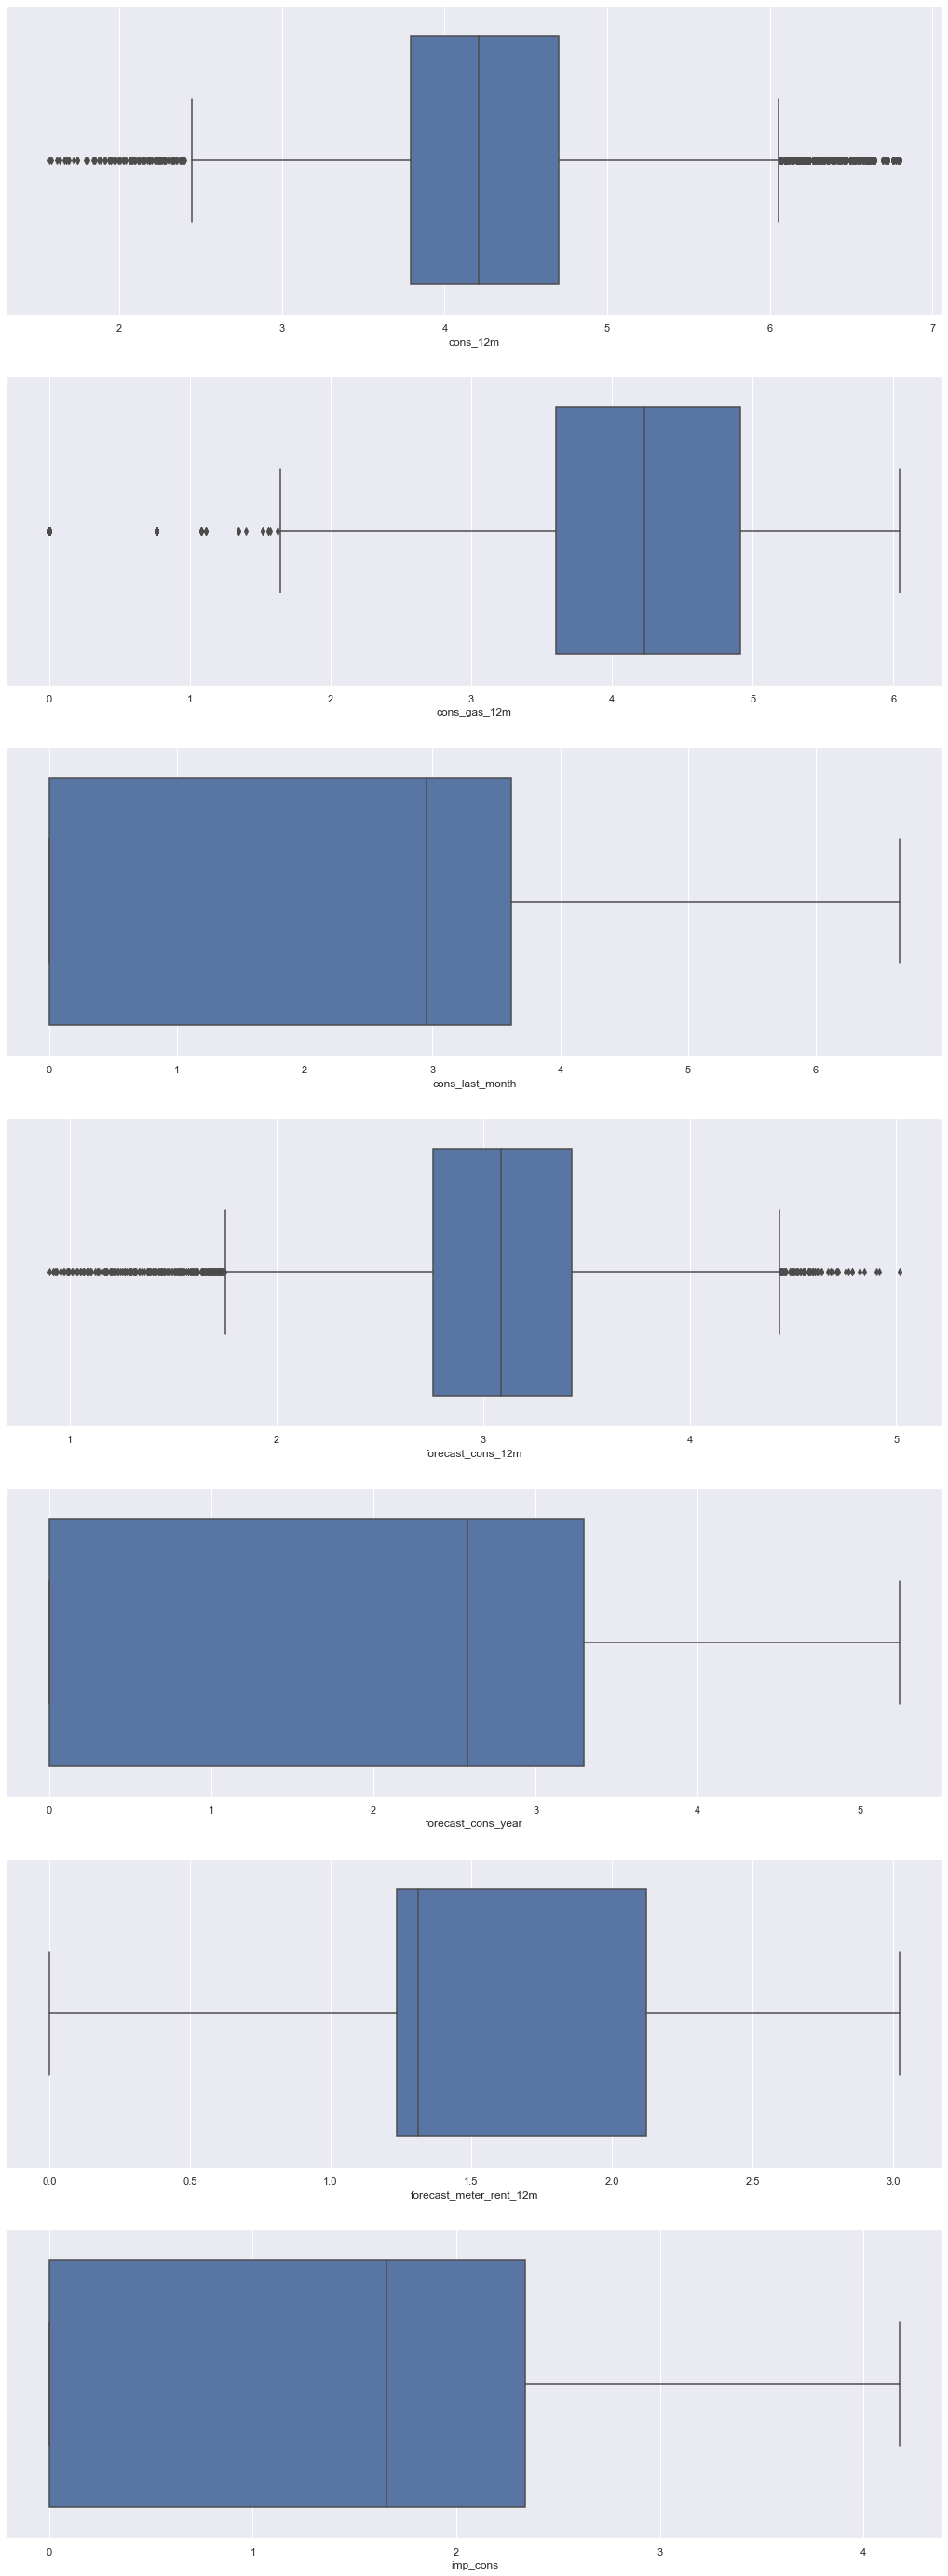

In [62]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

## 5. Multicollinearity

Multicollinearity occurs when the one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. 

Decision trees and boosted trees algorithms are immune to multicollinearity by nature. When they decide to split, the tree will choose only one of the perfectly correlated features. However, other problems such as Logistic Regression or Linear Regression are affected by the multicollinearity problem and would need to be fixed before training the model.

Calculate the correlation of the features

In [63]:
correlation = features.corr()

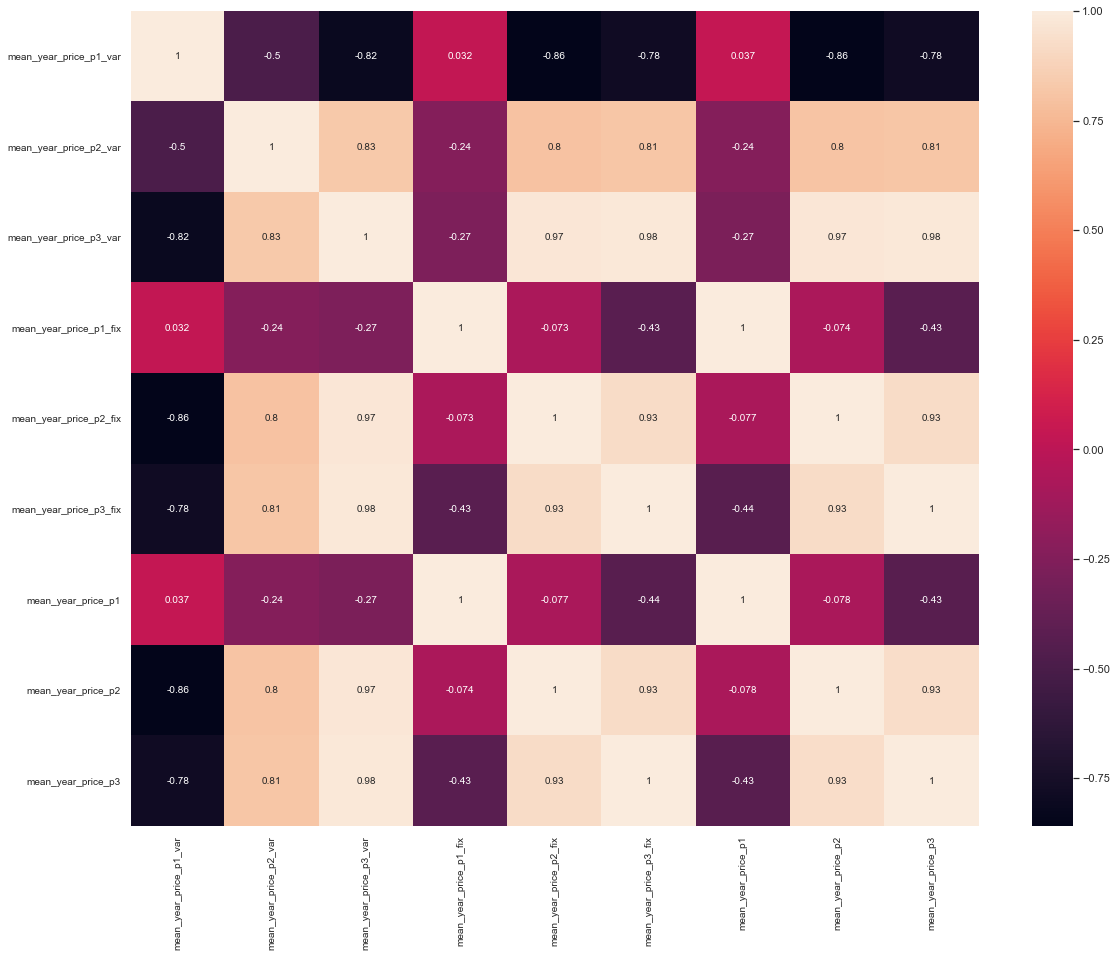

In [64]:
# Plot the correlation 
plt.figure(figsize=(19,15))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})

# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Calculate correlation for the trian data

In [65]:
correlation = train.corr()

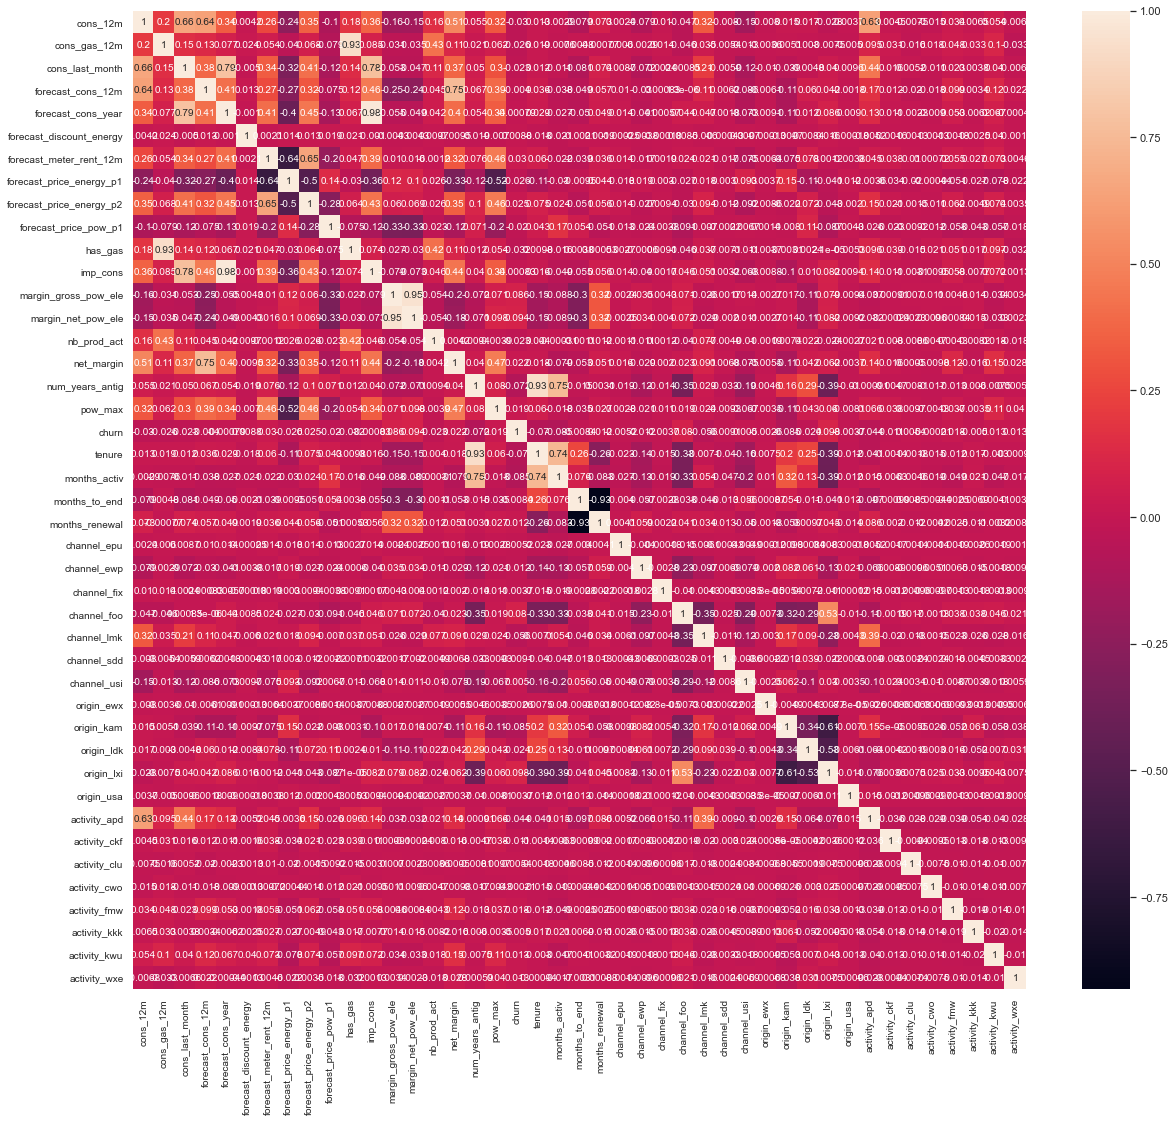

In [66]:
# Plot the correlation 
plt.figure(figsize=(20,18))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})

# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

As expected, num_years_antig has a high correlation with months_activ (it provides us with the same information).

In [67]:
#remove variables with very high correlation
train.drop(columns=["num_years_antig", "forecast_cons_year"], inplace=True)

#### Merge features and train data into single dataframe

In [68]:
train = pd.merge(train, features, on="id")

## 6. Pickling

We will pickle the data so that we can easily retrieve it in for the next exercise

In [69]:
PICKLE_TRAIN_DIR = os.path.join("..", "processed_data", "train_data.pkl")
PICKLE_HISTORY_DIR = os.path.join("..", "processed_data", "history_data.pkl")

In [70]:
pd.to_pickle(train, PICKLE_TRAIN_DIR)
pd.to_pickle(history_data, PICKLE_HISTORY_DIR)